In [1]:
try:
    import mlagents
    print("ml-agents already installed")
except ImportError:
    !python -m pip install -q mlagents==0.27.0
    print("Installed ml-agents")

ml-agents already installed


# Q-Learning Keras

In [10]:
import random
import tensorflow as tf
import numpy as np
import datetime
import traceback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Conv2D, Flatten, concatenate, MaxPooling2D, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import Huber, LogCosh, CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from collections import Counter

from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.environment import ActionTuple, BaseEnv

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Deep Q-Learning

In [4]:
behavior_name = 'AlphaRomeo?team=0'

In [36]:
num_actions = 9


def create_q_model():
    #Rede conolucional
    inputs = Input(shape=(84, 84, 3,))

    layer1 = Conv2D(32, 10, strides=1, activation="relu")(inputs)
    layer2 = MaxPooling2D(pool_size=(2, 2))(layer1)
    layer3 = Conv2D(32, 12, strides=1, activation="relu")(layer2)
    layer4 = MaxPooling2D(pool_size=(2, 2))(layer3)
    layer5 = Dropout(0.5)(layer4)
    

    layer6 = Flatten()(layer5)
    conv_output = Dense(128, activation="relu")(layer6)
    conv_output_model = Model(inputs=inputs, outputs=conv_output)

    #Rede Neural
    numerical_inputs = Input(shape=(2))
    layer7 = Dense(128, activation="relu")(numerical_inputs)
    layer8 = Dense(128, activation="relu")(layer7)
    numerical_output = Dense(128, activation="linear")(layer8)

    numerical_output_model = Model(inputs=numerical_inputs, outputs=numerical_output)

    #as duas saídas combinadas
    combined = concatenate([conv_output_model.output, numerical_output_model.output])

    layer9 = Dense(128, activation="relu")(combined)
    layer10 = Dense(128, activation="relu")(layer9)

    action = Dense(num_actions, activation="linear")(layer10)

    return Model(inputs=[conv_output_model.input, numerical_output_model.input], outputs=action)


model = create_q_model()

model_target = create_q_model()

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 84, 84, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 75, 75, 32)   9632        ['input_5[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 37, 37, 32)  0           ['conv2d_4[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 26, 26, 32)   147488      ['max_pooling2d_4[0][0]']        
                                                                                            

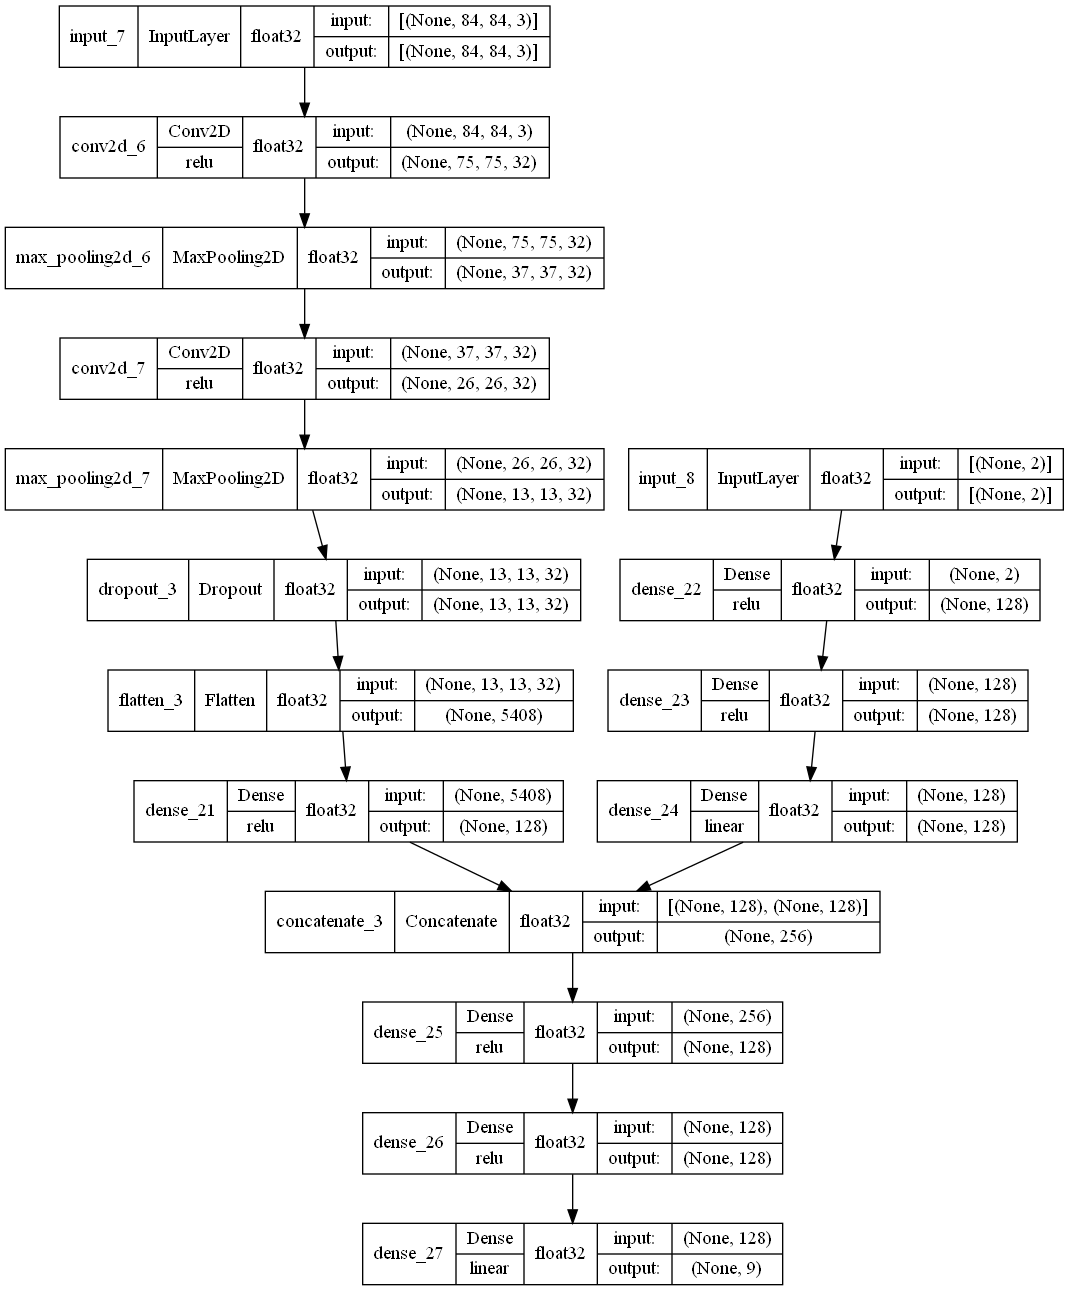

In [37]:
plot_model(model_target, show_shapes=True, show_dtype=True, show_layer_activations=True)

In [13]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = RMSprop(learning_rate=0.0025, clipnorm=1.0)

# Configuration paramaters for the whole setup
gamma = 0.01  # Discount factor for past rewards
epsilon = 0.5  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
max_steps_per_episode = 10000
batch_size = 128

# Memórias de repetição de experiência
action_history = []
state_conv_history = []
state_conv_next_history = []
state_num_history = []
state_num_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 1000
# Number of frames for exploration
epsilon_greedy_frames = 100000
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 1000
# Train the model after 4 actions
update_after_actions = 20
# How often to update the target network
update_target_network = 100
# Using huber loss for stability
loss_function=Huber()

In [14]:
env = UnityEnvironment(file_name="Alpha Romeo", seed=1, side_channels=[], worker_id=2)

log_folder = 'logs/{}'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = tf.summary.create_file_writer(log_folder)

# tf.debugging.experimental.enable_dump_debug_info(log_folder, tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

try:
    while True:  # Run until solvedloss_function
        with writer.as_default():
            env.reset()
            done = False
            decision_steps, terminal_steps = env.get_steps(behavior_name)
            if decision_steps:
                state_conv = decision_steps[0].obs[0]
                state_num = decision_steps[0].obs[1]
            if terminal_steps:
                done = True                
                state_conv = decision_steps[0].obs[0]
                state_numerical = decision_steps[0].obs[1]
                         
            episode_reward = 0

            for timestep in range(1, max_steps_per_episode):
                # env.render(); Adding this line would show the attempts
                # of the agent in a pop up window.
                frame_count += 1

                # Use epsilon-greedy for exploration
                if  frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
                    # Take random action
                    action = random.choice([1,2,3,4,5])
                    
                else:
                    # Predict action Q-values
                    # From environment state
                    state_conv_tensor = tf.convert_to_tensor(state_conv)
                    state_num_tensor = tf.convert_to_tensor(state_num)
                    state_conv_tensor = tf.expand_dims(state_conv_tensor, 0)
                    state_num_tensor = tf.expand_dims(state_num_tensor, 0)
                    action_probs = model([state_conv_tensor, state_num_tensor], training=False)
                    # Take best action
                    action = action_probs[0]
                    action = int(tf.argmax(action)+1)
                    

                # Decay probability of taking random action
                epsilon -= epsilon_interval / epsilon_greedy_frames
                epsilon = max(epsilon, epsilon_min)

                # Apply the sampled action in our environment

                action_tuple = ActionTuple()
                action_tuple.add_discrete(np.array([[action]]))
                
                env.set_actions(behavior_name, action_tuple)
                
                env.step()

                decision_steps, terminal_steps = env.get_steps(behavior_name)

                if terminal_steps:
                    reward = -100#terminal_steps[0].reward
                    state_conv_next = terminal_steps[0].obs[0]
                    state_num_next = terminal_steps[0].obs[1]
                    episode_reward += reward
                    # Save actions and states in replay buffer
                    action_history.append(action)
                    state_conv_history.append(state_conv)
                    state_num_history.append(state_num)
                    state_conv_next_history.append(state_conv_next)
                    state_num_next_history.append(state_num_next)
                    done_history.append(done) 
                    rewards_history.append(reward)
    #                 decision_steps, terminal_steps = env.get_steps(behavior_name)
                    break

                else:
                    state_conv_next = decision_steps[0].obs[0]
                    state_num_next = decision_steps[0].obs[1]


                reward = decision_steps[0].reward
        #         state_next = np.array(state_next)

                episode_reward += reward
                # Save actions and states in replay buffer
                action_history.append(action)
                state_conv_history.append(state_conv)
                state_num_history.append(state_num)
                state_conv_next_history.append(state_conv_next)
                state_num_next_history.append(state_num_next)
                done_history.append(done) 
                rewards_history.append(reward)
                state_conv = state_conv_next
                state_num = state_num_next

                # Update every fourth frame and once batch size is over 32
                if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

                    # Selecionar índices aleatóriamente
                    indices = np.random.choice(range(len(done_history)), size=batch_size)

                    # Usando list comprehension para buscar os valores dos índices selecionados
                    state_conv_sample = np.array([state_conv_history[i] for i in indices])
                    state_num_sample = np.array([state_num_history[i] for i in indices])
                    state_conv_next_sample = np.array([state_conv_next_history[i] for i in indices])
                    state_num_next_sample = np.array([state_num_next_history[i] for i in indices])
                    rewards_sample = [rewards_history[i] for i in indices]
                    action_sample = [action_history[i] for i in indices]
                    done_sample = tf.convert_to_tensor(
                        [float(done_history[i]) for i in indices]
                    )

                    # Build the updated Q-values for the sampled future states
                    # Use the target model for stability
                    state_num_next_sample = tf.reshape(state_num_next_sample, [-1, 2])
                    future_rewards = model_target.predict([np.array(state_conv_next_sample), np.array(state_num_next_sample)])

                    # Q value = reward + discount factor * expected future reward
                    updated_q_values = rewards_sample + gamma * tf.reduce_max(
                        future_rewards, axis=1
                    )

                    # If final frame set the last value to -1
                    updated_q_values = updated_q_values * (1 - done_sample) - done_sample

                    # Create a mask so we only calculate loss on the updated Q-values

                    masks = tf.one_hot(action_sample, num_actions)

                    with tf.GradientTape() as tape:
                        # Train the model on the states and updated Q-values
                        q_values = model([np.array(state_conv_sample), np.array(state_num_sample)])


                        # Apply the masks to the Q-values to get the Q-value for action taken
                        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)

                        # Calculate loss between new Q-value and old Q-value

                        loss = loss_function(updated_q_values, q_action)

                    # Backpropagation
                    grads = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(grads, model.trainable_variables))

                if frame_count % update_target_network == 0:
                    # update the the target network with new weights
                    model_target.set_weights(model.get_weights())
                    # Log details
                    template = "A: {} , running reward: {:.2f} at episode {}, frame count {}"
                    print(template.format(dict(Counter(action_history)), running_reward, episode_count, frame_count))
                    tf.summary.scalar(name="running reward", data=running_reward, step=episode_count)
                    tf.summary.scalar(name="reward", data=reward, step=episode_count)
                    tf.summary.scalar(name="epsilon", data=epsilon, step=episode_count)
                    tf.summary.scalar(name="frame_count", data=frame_count, step=episode_count)
                    dqn_variable = model.trainable_variables
                    tf.summary.histogram(name="dqn_variables", data=tf.convert_to_tensor(dqn_variable[0]), step=episode_count)
                    tf.summary.histogram(name="actions", data=action, step=episode_count)
#                     convs = np.reshape(model.layers[4].get_weights()[0], (-1, 9, 9, 1))
#                     tf.summary.image("Training data", data=convs[:5, :, :, :], step=episode_count)
                    writer.flush()
                    
            # Limit the state and reward history
            if len(rewards_history) > max_memory_length:
                del rewards_history[:1]
                del state_conv_history[:1]
                del state_num_history[:1]
                del state_conv_next_history[:1]
                del state_num_next_history[:1]
                del action_history[:1]
                del done_history[:1]

            if done:
                env.reset()
                done = False


            # Update running reward to check condition for solving
            episode_reward_history.append(episode_reward)
            if len(episode_reward_history) > 100:
                del episode_reward_history[:1]
            running_reward = np.mean(episode_reward_history)

            episode_count += 10

            if running_reward > 500000:  # Condition to consider the task solved
                print("Solved at episode {}!".format(episode_count))
                writer.close()
                env.close()
                break
except:
    print(traceback.print_exc())
    writer.close()
    env.close()

A: {3: 23, 4: 12, 1: 20, 2: 27, 5: 18} , running reward: -254.00 at episode 10, frame count 100
A: {3: 50, 4: 33, 1: 37, 2: 45, 5: 35} , running reward: -254.00 at episode 10, frame count 200
A: {3: 68, 4: 57, 1: 54, 2: 60, 5: 61} , running reward: -414.00 at episode 20, frame count 300
A: {3: 82, 4: 81, 1: 74, 2: 84, 5: 79} , running reward: -486.00 at episode 30, frame count 400
A: {3: 96, 4: 102, 1: 100, 2: 100, 5: 102} , running reward: -427.50 at episode 40, frame count 500
A: {3: 116, 4: 122, 1: 119, 2: 118, 5: 125} , running reward: -438.40 at episode 50, frame count 600
A: {3: 140, 4: 143, 1: 137, 2: 133, 5: 147} , running reward: -387.33 at episode 60, frame count 700
A: {3: 156, 4: 173, 1: 155, 2: 156, 5: 160} , running reward: -363.71 at episode 70, frame count 800
A: {3: 174, 4: 192, 1: 170, 2: 185, 5: 179} , running reward: -325.11 at episode 90, frame count 900
A: {3: 193, 4: 211, 1: 188, 2: 199, 5: 209} , running reward: -310.20 at episode 100, frame count 1000
A: {3: 21

Traceback (most recent call last):
  File "C:\Users\carlo\AppData\Local\Temp/ipykernel_1436/645152202.py", line 118, in <module>
    future_rewards = model_target.predict([np.array(state_conv_next_sample), np.array(state_num_next_sample)])
  File "C:\Users\carlo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\keras\engine\training.py", line 1789, in predict
    tmp_batch_outputs = self.predict_function(iterator)
  File "C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 910, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 949, in _call
    results = self._stateful_fn(*args, **kwd

None


In [15]:
c = Counter(action_history)
sum_actions = 0
d = dict(c)
for k,v in d.items():
    sum_actions += v
print("Total:", sum_actions)

for k,v in d.items():
    print(f"{k}:{v/sum_actions}")   

Total: 105755
3:0.05235686255968985
4:0.05945818164625786
5:0.18519218949458655
1:0.6130112051439648
2:0.08998156115550092


In [16]:
model.layers

In [33]:
# model.layers[9].get_weights()

In [34]:
for l in range(12):
    print(l)
    try:
        np.save("./weights/"+str(model.layers[l].__class__).split(".")[-1][:-2]+"_pista1_"+str(l), model.layers[l].get_weights())
    except:
        np.save("./weights/"+str(model.layers[l].__class__).split(".")[-1][:-2]+"_w_pista1_"+str(l), model.layers[l].get_weights()[0])
        np.save("./weights/"+str(model.layers[l].__class__).split(".")[-1][:-2]+"_b_pista1_"+str(l), model.layers[l].get_weights()[1])

0
1
2
3
4
5
6
7
8
9
10
11


In [50]:
conv.get_weights()[0].

(16, 16, 3, 64)

In [27]:
np.save('conv1', conv.get_weights())

C:\Users\carlo\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [29]:
t = np.load('./conv1.npy', allow_pickle=True)

In [35]:
model.layers[9].get_weights()

[array([[-0.149283  ,  0.05679303,  0.0555075 , ...,  0.04539962,
          0.10271643, -0.05063693],
        [ 0.01640223, -0.02381094, -0.09102789, ...,  0.10347052,
          0.01546592, -0.06914121],
        [-0.12232754, -0.09958978, -0.07677111, ..., -0.05627783,
         -0.08530734, -0.14571871],
        ...,
        [ 0.10753857,  0.11774588,  0.1041832 , ..., -0.05335679,
         -0.00498893, -0.2736516 ],
        [-0.04479993,  0.07875134, -0.06205639, ..., -0.1269941 ,
         -0.14091854,  0.19950674],
        [-0.09730139, -0.00841362,  0.12681738, ..., -0.06441584,
          0.08083618, -0.12733778]], dtype=float32),
 array([-0.03884863, -0.05495053, -0.0233268 , -0.04156088,  0.07973326,
        -0.09212336, -0.01407017, -0.01580215, -0.0395433 , -0.02908045,
        -0.03261843, -0.01392152, -0.05189411, -0.03256547, -0.00943885,
         0.1773047 , -0.01933138, -0.03992323, -0.03139216, -0.00215567,
         0.1835018 ,  0.19413677, -0.04033056, -0.03295835, -0.007

In [ ]:
#exemplo de como salvar pesos e bias
weights_and_bias = model.layers[9].get_weights()
np.save("./pesos_camada_9.npy", weights_and_bias[0])
np.save("./bias_camada_9.npy", weights_and_bias[1])

#exemplo de como carregar pesos e bias
weights = np.load('./pesos_camada_9.npy', allow_pickle=True)
bias = np.load('./bias_camada_9.npy', allow_pickle=True)
weights_and_bias = [weights, bias]
model.layers[9].set_weights(weights_and_bias)

In [24]:
np.save("./weights/"+str(model.layers[l].__class__).split(".")[-1][:-2]+"_pista1_"+str(l), model.layers[9].get_weights())

ValueError: could not broadcast input array from shape (128,128) into shape (128,)

In [41]:
model.layers[1].__class__

keras.layers.convolutional.Conv2D

In [17]:
import matplotlib.pyplot as plt
import numpy as np

In [52]:
model.layers[4].get_weights()[0].shape

(13, 13, 64, 64)

In [46]:
resh = np.reshape(model.layers[4].get_weights()[0], (-1, 9, 9, 1))

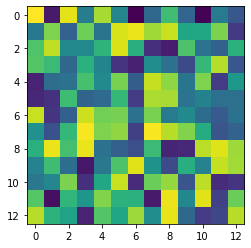

In [55]:
# for i in 
plt.imshow(model.layers[4].get_weights()[0][:,:,63,61])

In [43]:
state_conv_history[0]

array([[[0.4745098 , 0.5803922 , 0.7254902 ],
        [0.4745098 , 0.5803922 , 0.7254902 ],
        [0.4745098 , 0.5764706 , 0.72156864],
        ...,
        [0.48235294, 0.5882353 , 0.7372549 ],
        [0.48235294, 0.5882353 , 0.7372549 ],
        [0.4862745 , 0.5921569 , 0.7411765 ]],

       [[0.48235294, 0.5882353 , 0.73333335],
        [0.48235294, 0.58431375, 0.7294118 ],
        [0.47843137, 0.58431375, 0.7294118 ],
        ...,
        [0.4862745 , 0.5921569 , 0.7411765 ],
        [0.4862745 , 0.59607846, 0.74509805],
        [0.49019608, 0.59607846, 0.74509805]],

       [[0.4862745 , 0.59607846, 0.7411765 ],
        [0.4862745 , 0.5921569 , 0.7372549 ],
        [0.4862745 , 0.5921569 , 0.7372549 ],
        ...,
        [0.49019608, 0.6       , 0.74509805],
        [0.49411765, 0.6       , 0.7490196 ],
        [0.49411765, 0.6039216 , 0.7490196 ]],

       ...,

       [[0.25882354, 0.6039216 , 0.42352942],
        [0.25490198, 0.6039216 , 0.42352942],
        [0.25490198, 0

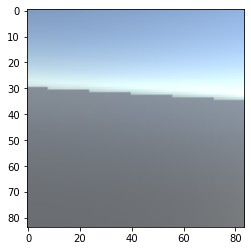

In [19]:
plt.imshow(state_conv_history[8140], cmap='gray')

In [47]:
resh.shape

(16384, 9, 9, 1)

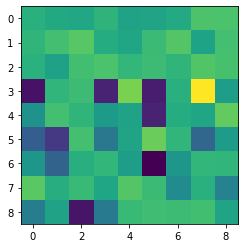

In [53]:
plt.imshow(resh[6, :,:,:])

In [7]:
env.close()

UnityEnvironmentException: No Unity environment is loaded.